In [1]:
# Download dataset. This is not needed if you have the dataset already

# import kagglehub

# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path)

In [1]:
# Function to check the sampling rate of a wav file and valid file path

import wave
import contextlib

def check_sampling_rate(file_path):
    try:
        with contextlib.closing(wave.open(file_path, 'r')) as wav_file:
            sample_rate = wav_file.getframerate()
            print(f"Sampling rate: {sample_rate} Hz")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
file_path = 'data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-01-01-01.wav'
check_sampling_rate(file_path)

Sampling rate: 48000 Hz


In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.2.2
2.2.2


In [4]:
"""
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).
"""


import os
import pandas as pd

emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

file_dir = "data/ravdess-emotional-speech-audio/versions/1/"

data = []

for actor in os.listdir(file_dir):
    actor_path = os.path.join(file_dir, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file[6:8]
                emotion = emotion_mapping.get(emotion_code, "unknown")

                file_path = os.path.join(actor_path, file)

                data.append({"emotion": emotion, "file_path": file_path})

df = pd.DataFrame(data)

print(df)

      emotion                                          file_path
0       angry  data/ravdess-emotional-speech-audio/versions/1...
1     fearful  data/ravdess-emotional-speech-audio/versions/1...
2     fearful  data/ravdess-emotional-speech-audio/versions/1...
3       angry  data/ravdess-emotional-speech-audio/versions/1...
4     disgust  data/ravdess-emotional-speech-audio/versions/1...
...       ...                                                ...
1435    happy  data/ravdess-emotional-speech-audio/versions/1...
1436    happy  data/ravdess-emotional-speech-audio/versions/1...
1437     calm  data/ravdess-emotional-speech-audio/versions/1...
1438     calm  data/ravdess-emotional-speech-audio/versions/1...
1439  neutral  data/ravdess-emotional-speech-audio/versions/1...

[1440 rows x 2 columns]


In [14]:
#remove calm emotion
df = df[df.emotion != 'calm']


In [5]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import torch
import matplotlib.pyplot as plt

torch.random.manual_seed(42)

SAMPLE_SPEECH = "data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-02-01-01.wav"


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [6]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

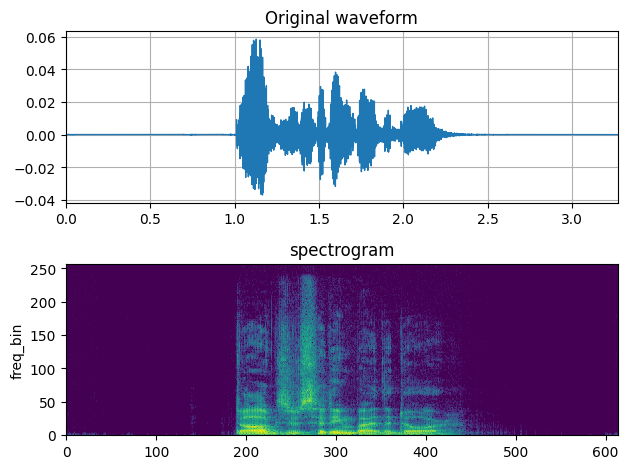

In [7]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout() 

In [8]:
import numpy as np

spec.numpy()

array([[[1.92024654e-05, 5.83025212e-07, 1.10596675e-05, ...,
         3.95150437e-06, 2.99906078e-05, 4.87497800e-07],
        [1.10033625e-05, 2.03892591e-06, 5.64487027e-06, ...,
         6.28824455e-06, 1.90358132e-05, 5.21412460e-07],
        [1.90091748e-06, 2.83813421e-07, 5.14554870e-07, ...,
         1.55791474e-06, 4.33985451e-06, 3.46728768e-07],
        ...,
        [5.36916431e-08, 2.08570778e-08, 7.67220687e-09, ...,
         3.32698380e-09, 6.41428244e-09, 1.51021364e-08],
        [6.38599715e-08, 1.53289434e-08, 3.89846738e-10, ...,
         2.35564124e-09, 2.71023071e-09, 1.82372979e-08],
        [2.24144401e-08, 4.90383343e-08, 5.23877208e-09, ...,
         5.26674215e-09, 1.87662264e-09, 2.23065104e-08]]], dtype=float32)

In [15]:

X = []
y = []

for index, row in df.iterrows():
  SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(row)
  # Define transform
  spectrogram = T.Spectrogram(n_fft=512)
  # Perform transform
  spec = spectrogram(SPEECH_WAVEFORM)
  X.append(spec.numpy)
  y.append(row['emotion']) # need to convert to 0-7 numbers somewhere earlier 


RuntimeError: torchaudio_sox::load_audio_file() Expected a value of type 'str' for argument '_0' but instead found type 'Series'.
Position: 0
Value: emotion                                                  angry
file_path    data/ravdess-emotional-speech-audio/versions/1...
Name: 0, dtype: object
Declaration: torchaudio_sox::load_audio_file(str _0, int? _1, int? _2, bool? _3, bool? _4, str? _5) -> (Tensor _0, int _1)
Cast error details: Unable to cast Python instance of type <class 'pandas.core.series.Series'> to C++ type '?' (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)